Printed copies of *Elements of Data Science* are available now, with a **full color interior**, from [Lulu.com](https://www.lulu.com/shop/allen-downey/elements-of-data-science/paperback/product-9dyrwn.html).

# DataFrames and Series

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/v1/07_dataframes.ipynb).

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

import utils

Downloaded utils.py


This chapter introduces Pandas, a Python library that provides functions for reading and writing data files, exploring and analyzing data, and generating visualizations.
And it provides two new types for working with data, `DataFrame` and `Series`.

We will use these tools to answer a data question -- what is the average birth weight of babies in the United States?
This example will demonstrate important steps in almost any data science project:

1. Identifying data that can answer a question.

2. Obtaining the data and loading it in Python.

3. Checking the data and dealing with errors.

4. Selecting relevant subsets from the data.

5. Using histograms to visualize a distribution of values.

6. Using summary statistics to describe the data in a way that best answers the question.

7. Considering possible sources of error and limitations in our conclusions.

Let's start by getting the data.

## Reading the Data

To estimate average birth weight, we'll use data from the National Survey of Family Growth (NSFG), which is available from the National Center for Health Statistics.
To download the data, you have to agree to the Data User's Agreement.
URLs for the data and the agreement are in the notebook for this chapter.

The NSFG data is available from <https://www.cdc.gov/nchs/nsfg>.

The Data User's Agreement is at <https://www.cdc.gov/nchs/data_access/ftp_dua.htm>.

You should read the terms carefully, but let me draw your attention to what I think is the most important one:

> Make no attempt to learn the identity of any person or establishment included in these data.

NSFG respondents answer questions of the most personal nature with the expectation that their identities will not be revealed.
As ethical data scientists, we should respect their privacy and adhere to the terms of use.

Respondents to the NSFG provide general information about themselves, which is stored in the respondent file, and information about each time they have been pregnant, which is stored in the pregnancy file.

We will work with the pregnancy file, which contains one row for each pregnancy and one column for each question on the NSFG questionnaire.

The data is stored in a fixed-width format, which means that every row is the same length and each column spans a fixed range of characters.
For example, the first six characters in each row represent a a unique identifier for each respondent; the next two characters indicate whether a pregnancy is the respondent's first, second, etc.

To read this data, we need a **data dictionary**, which specifies the names of the columns and the index where each one begins and ends.
The data and the data dictionary are available in separate files.
Instructions for downloading them are in the notebook for this chapter.

In [2]:
dict_file = '2015_2017_FemPregSetup.dct'
data_file = '2015_2017_FemPregData.dat'

Once you have agreed to the terms, you can use the following cells to download the data.

In [3]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/datasets/NSFG/stata/' + dict_file)

Downloaded 2015_2017_FemPregSetup.dct


'2015_2017_FemPregSetup.dct'

In [4]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/datasets/NSFG/' + data_file)

Downloaded 2015_2017_FemPregData.dat


'2015_2017_FemPregData.dat'

Pandas can read data in most common formats, including CSV, Excel, and fixed-width format, but it cannot read the data dictionary, which is in Stata format.
For that, we'll use a Python library called `statadict`.

The following cell installs `statadict` if necessary.

In [5]:
try:
    from statadict import parse_stata_dict
except ImportError:
    !pip install statadict

From `statadict`, we'll import `parse_stata_dict`, which reads the data dictionary.

In [6]:
from statadict import parse_stata_dict

stata_dict = parse_stata_dict(dict_file)
stata_dict

The result is an object that contains

* `names`, which is a list of column names, and

* `colspecs`, which is a list of tuples, where each tuple contains the first and last index of a column.

These values are exactly the arguments we need to use `read_fwf`, which is the Pandas function that reads a file in fixed-width format.

In [7]:
import pandas as pd

nsfg = pd.read_fwf(data_file,
                   names=stata_dict.names,
                   colspecs=stata_dict.colspecs)
type(nsfg)

pandas.core.frame.DataFrame

The result is a `DataFrame`, which is the primary type Pandas uses to store data.
`DataFrame` has a method called `head` that shows the first 5 rows:

In [8]:
nsfg.head()

,CASEID,PREGORDR,HOWPREG_N,HOWPREG_P,MOSCURRP,NOWPRGDK,PREGEND1,PREGEND2,HOWENDDK,NBRNALIV,...,SECU,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR
0,70627,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
1,70627,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,3,322,1394,1382,1357,1345,1333,18,1,2016
2,70627,3,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
3,70628,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017
4,70628,2,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017


In [ ]:
# Solution goes here

The first two columns are `CASEID` and `PREGORDR`, which I mentioned earlier.
The first three rows have the same `CASEID`, which means this respondent reported three pregnancies.
The values of `PREGORDR` indicate that they are the first, second, and third pregnancies, in that order.
We will learn more about the other columns as we go along.

In addition to methods like `head`, a `Dataframe` object has several **attributes**, which are variables associated with the object.
For example, `nsfg` has an attribute called `shape`, which is a tuple containing the number of rows and columns:

In [9]:
nsfg.shape

(9553, 248)

There are 9553 rows in this dataset, one for each pregnancy, and 248 columns, one for each question.
`nsfg` also has an attribute called `columns`, which contains the column names:

In [11]:
nsfg.columns

Index(['CASEID', 'PREGORDR', 'HOWPREG_N', 'HOWPREG_P', 'MOSCURRP', 'NOWPRGDK',
       'PREGEND1', 'PREGEND2', 'HOWENDDK', 'NBRNALIV',
       ...
       'SECU', 'SEST', 'CMINTVW', 'CMLSTYR', 'CMJAN3YR', 'CMJAN4YR',
       'CMJAN5YR', 'QUARTER', 'PHASE', 'INTVWYEAR'],
      dtype='object', length=248)

The column names are stored in an `Index`, which is another Pandas type, similar to a list.

In [12]:
type(nsfg.columns)

pandas.core.indexes.base.Index

Based on the names, you might be able to guess what some of the columns are, but in general you have to read the documentation.
When you work with datasets like the NSFG, it is important to read the documentation carefully.
If you interpret a column incorrectly, you can generate nonsense results and never realize it.

So, before we start looking at data, let's get familiar with the NSFG codebook, which describes every column.
Instructions for downloading it are in the notebook for this chapter.

You can download the codebook for this dataset from <https://github.com/AllenDowney/ElementsOfDataScience/raw/v1/data/2015-2017_NSFG_FemPregFile_Codebook-508.pdf>.

If you search that document for "weigh at birth" you should find these columns related to birth weight.

* `BIRTHWGT_LB1`: Birthweight in Pounds - 1st baby from this pregnancy

* `BIRTHWGT_OZ1`: Birthweight in Ounces - 1st baby from this pregnancy

There are similar columns for a 2nd or 3rd baby, in the case of twins or triplets.
For now we will focus on the first baby from each pregnancy, and we will come back to the issue of multiple births.

## Series

In many ways a `DataFrame` is like a Python dictionary, where the column names are the keys and the columns are the values.
You can select a column from a `DataFrame` using the bracket operator, with a string as the key.

In [13]:
pounds = nsfg['BIRTHWGT_LB1']
type(pounds)

pandas.core.series.Series

The result is a `Series`, which is a Pandas type that represents a single column of data.
In this case the `Series` contains the birth weight, in pounds, for each live birth.

`head` shows the first five values in the `Series`, the name of the `Series`, and the data type:

In [14]:
pounds.head()

,BIRTHWGT_LB1
0,7.0
1,NaN
2,9.0
3,6.0
4,7.0


One of the values is `NaN`, which stands for "Not a Number".
`NaN` is a special value used to indicate invalid or missing data.
In this example, the pregnancy did not end in live birth, so birth weight is inapplicable.

**Exercise:**  The column `BIRTHWGT_OZ1` contains the ounces part of birth weight.
Select this column from `nsfg` and assign it to a new variable called `ounces`.
Then display the first 5 elements of `ounces`.

In [18]:
# Solution goes here

ounces = nsfg['BIRTHWGT_OZ1']

ounces.head()

,BIRTHWGT_OZ1
0,8.0
1,NaN
2,2.0
3,9.0
4,0.0


**Exercise:** The Pandas types we have seen so far are `DataFrame`, `Index`, and `Series`.  You can find the documentation of these types at:

* `DataFrame`: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html>

* `Index`: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.html>

* `Series`: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html>

This documentation can be overwhelming -- I don't recommend trying to read it all now.
But you might want to skim it so you know where to look later.

## Validation

At this point we have identified the columns we need to answer the question and assigned them to variables named `pounds` and `ounces`.

In [19]:
pounds = nsfg['BIRTHWGT_LB1']
ounces = nsfg['BIRTHWGT_OZ1']

Before we do anything with this data, we have to validate it.
One part of validation is confirming that we are interpreting the data correctly.
We can use the `value_counts` method to see what values appear in `pounds` and how many times each value appears.
With `dropna=False`, it includes NaNs.
By default, the results are sorted with the highest count first, but we can use `sort_index` to sort them by value instead, with the lightest babies first and heaviest babies last.

In [22]:
pounds.value_counts(dropna=False).sort_index()

,count
BIRTHWGT_LB1,
0.0,2
1.0,28
2.0,46
3.0,76
4.0,179
5.0,570
6.0,1644
7.0,2268
8.0,1287


The values are in the left column and the counts are in the right column.
The most frequent values are 6-8 pounds, but there are some very light babies, a few very heavy babies, and two special values, 98, and 99.  According to the codebook, these values indicate that the respondent declined to answer the question (98) or did not know (99).

We can validate the results by comparing them to the codebook, which lists the values and their frequencies.

 Value | Label             | Total
------:|:------------------|------:
 .     | INAPPLICABLE      | 2863  
 0-5   | UNDER 6 POUNDS    | 901   
 6     | 6 POUNDS          | 1644  
 7     | 7 POUNDS          | 2268  
 8     | 8 POUNDS          | 1287  
 9-95  | 9 POUNDS OR MORE  | 499   
 98    | Refused           | 2     
 99    | Don't know        | 89    
       | Total             | 9553  


The results from `value_counts` agree with the codebook, so we can be confident that we are reading and interpreting the data correctly.

**Exercise:** In `nsfg`, the `OUTCOME` column encodes the outcome of each pregnancy as shown below:

| Value | Meaning |
|------:|:--------|
| 1     | Live birth |
| 2     | Induced abortion |
| 3     | Stillbirth |
| 4     | Miscarriage |
| 5     | Ectopic pregnancy |
| 6     | Current pregnancy |

Use `value_counts` to display the values in this column and how many times each value appears.  Are the results consistent with the codebook?

In [26]:
# Solution goes here

outcome = nsfg['OUTCOME']
outcome.value_counts().sort_index()

,count
OUTCOME,
1,6693
2,901
3,120
4,1515
5,123
6,201


## Summary Statistics

Another way to validate the data is with `describe`, which computes statistics that summarize the data, like the mean, standard deviation, minimum, and maximum.
Here are the results for `pounds`.  

In [27]:
pounds.describe()

,BIRTHWGT_LB1
count,6690.000000
mean,8.008819
std,10.771360
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,99.000000


`count` is the number of values, not including `NaN`.
`mean` and `std` are the mean and standard deviation.
`min` and `max` are the minimum and maximum values, and in between are the 25th, 50th, and 75th percentiles.
The 50th percentile is the median.

The mean is about 8.05, but that doesn't mean much because it includes the special values `98` and `99`.
Before we can really compute the mean, we have to replace those values with `NaN` to identify them as missing data.
The `replace` method does what we want:

In [28]:
import numpy as np

pounds_clean = pounds.replace([98, 99], np.nan)

`replace` takes a list of the values we want to replace and the value we want to replace them with.
`np.nan` means we are getting the special value `NaN` from the NumPy library, which is imported as `np`.
The result is a new `Series`, which I assign to `pounds_clean`.
If we run `describe` again, we see that `count` is smaller now because it includes only the valid values.

In [29]:
pounds_clean.describe()

,BIRTHWGT_LB1
count,6599.000000
mean,6.754357
std,1.383268
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,14.000000


The mean of the new `Series` is about 6.7 pounds.
Remember that the mean of the original `Series` was more than 8 pounds.
It makes a big difference when you remove a few 99-pound babies!

The effect on standard deviation is even more dramatic.
If we include the values `98` and `99`, the standard deviation is 10.8.
If we remove them -- as we should -- the standard deviation is 1.4.

**Exercise:** Use `describe` to summarize `ounces`.
Then use `replace` to replace the special values `98` and `99` with `NaN`, and assign the result to `ounces_clean`.
Run `describe` again.
How much does this cleaning affect the results?

In [31]:
# Solution goes here
ounces_clean = ounces.replace([98,99], np.nan)


ounces_clean.describe()

,BIRTHWGT_OZ1
count,6540.000000
mean,6.790520
std,4.532309
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,15.000000


In [33]:
# Solution goes here


,BIRTHWGT_LB1
count,6690.000000
mean,8.008819
std,10.771360
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,99.000000


In [ ]:
# Solution goes here

## Series Arithmetic

Now we want to combine `pounds` and `ounces` into a single `Series` that contains total birth weight.
With `Series` objects, the arithmetic operators work elementwise, as they do with NumPy arrays.

So, to convert `pounds` to ounces, we can write `pounds * 16`.
Then, to add in `ounces` we can write `pounds * 16 + ounces`.

**Exercise:** Use `pounds_clean` and `ounces_clean` to compute the total birth weight expressed in kilograms (there are roughly 2.2 pounds per kilogram).  What is the mean birth weight in kilograms?

In [44]:
#Solution goes here

kilo = 0.45 * pounds_clean + ounces_clean / 35.27

kilo.describe()

,0
count,6540.000000
mean,3.232644
std,0.619799
min,0.226822
25%,2.898469
50%,3.263411
75%,3.600000
max,6.385058


## Histograms

Let's get back to the original question: what is the average birth weight for babies in the U.S.?  
As an answer we *could* take the results from the previous section and compute the mean:

In [40]:
pounds_clean = pounds.replace([98, 99], np.nan)
ounces_clean = ounces.replace([98, 99], np.nan)

birth_weight = pounds_clean + ounces_clean / 16
birth_weight.mean()

np.float64(7.180217889908257)

But it is risky to compute a summary statistic, like the mean, before we look at the whole distribution of values.
A **distribution** is a set of possible values and their frequencies.
One way to visualize a distribution is a **histogram**, which shows values on the x-axis and their frequencies on the y-axis.
`Series` provides a `hist` method that makes histograms, and we can use Pyplot to label the axes.

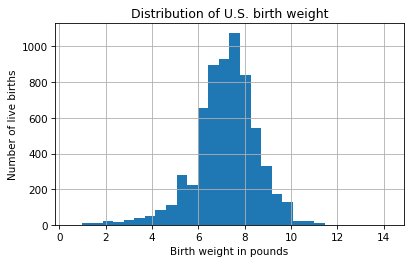

In [45]:
import matplotlib.pyplot as plt

birth_weight.hist(bins=30)
plt.xlabel('Birth weight in pounds')
plt.ylabel('Number of live births')
plt.title('Distribution of U.S. birth weight');

The keyword argument, `bins`, tells `hist` to divide the range of weights into 30 intervals, called **bins**, and count how many values fall in each bin.
The x-axis is birth weight in pounds; the y-axis is the number of births in each bin.

The distribution looks like a bell curve, but the tail is longer on the left than on the right -- that is, there are more light babies than heavy babies.
That makes sense, because the distribution includes some babies that were born preterm.

**Exercise:** `hist` takes keyword arguments that specify the type and appearance of the histogram.
Read the documentation of `hist` at <https://pandas.pydata.org/docs/reference/api/pandas.Series.hist.html> and see if you can figure out how to plot the histogram as an unfilled line against a background with no grid lines.

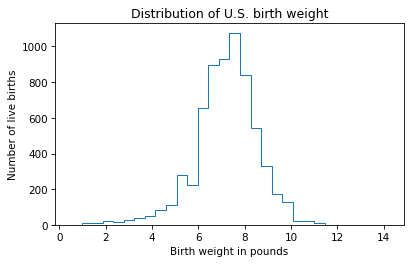

In [47]:
# Solution goes here
import matplotlib.pyplot as plt

birth_weight.hist(bins=30, grid = False, histtype = 'step')
plt.xlabel('Birth weight in pounds')
plt.ylabel('Number of live births')
plt.title('Distribution of U.S. birth weight');




**Exercise:** The NSFG dataset includes a column called `AGECON` that records a woman's age at conception for each pregnancy.
Select this column from the `DataFrame` and plot the histogram of the values with 20 bins.
Label the axes and add a title.

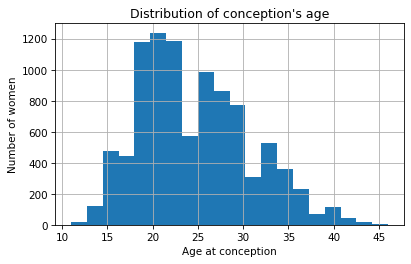

In [52]:
# Solution goes here


age = nsfg['AGECON']
age.hist(bins = 20)
plt.xlabel('Age at conception')
plt.ylabel('Number of women')
plt.title("Distribution of conception's age");

## Boolean Series

We have seen that the distribution of birth weights is **skewed** to the left -- that is, the left tail extends farther from the center than the right tail.
That's because preterm babies tend to be lighter.
To see which babies are preterm, we can use the `PRGLNGTH` column, which records pregnancy length in weeks.
A baby is considered preterm if it is born prior to the 37th week of pregnancy.

In [53]:
preterm = (nsfg['PRGLNGTH'] < 37)
preterm.dtype

dtype('bool')

When you compare a `Series` to a value, the result is a Boolean `Series` -- that is, a `Series` where each element is a Boolean value, `True` or `False`.
In this case, it's `True` for each preterm baby and `False` otherwise.
We can use `head` to see the first 5 elements.

In [54]:
preterm.head()

,PRGLNGTH
0,False
1,True
2,False
3,False
4,False


For a Boolean `Series`, the `sum`  method treats `True` as 1 and `False` as 0, so the result is the number of `True` values, which is the number of preterm babies.

In [55]:
preterm.sum()

np.int64(3675)

If you compute the mean of a Boolean `Series`, the result the *fraction* of `True` values.
In this case, it's about 0.38 -- which means about 38% of the pregnancies are less than 37 weeks in duration.

In [56]:
preterm.mean()

np.float64(0.38469590704490736)

However, this result is misleading because it includes all pregnancy outcomes, not just live births.
We can use the `OUTCOME` column to create another Boolean `Series` to indicate which pregnancies ended in live birth.

In [57]:
live = (nsfg['OUTCOME'] == 1)
live.mean()

np.float64(0.7006176070344394)

Now we can use the `&` operator, which represents the logical AND operation, to identify pregnancies where the outcome is a live birth *and* preterm:

In [58]:
live_preterm = (live & preterm)
live_preterm.mean()

np.float64(0.08929132209777034)

About 9% of all pregnancies resulted in a preterm live birth.

The other common logical operators that work with `Series` objects are:
    
* `|`, which represents the logical OR operation -- for example, `live | preterm` is true if either `live` is true, or `preterm` is true, or both.

* `~`, which represents the logical NOT operation -- for example, `~live` is true if `live` not true.

The logical operators treat `NaN` the same as `False`, so you should be careful about using the NOT operator with a Series that contains `NaN` values.
For example, `~preterm` would include not just full term pregnancies, but also pregnancies with unknown duration.

**Exercise:** Of all pregnancies, what fraction are live births at full term (37 weeks or more)?
Of all live births, what fraction are full term?

In [62]:
# Solution goes here

live_term = ((~preterm) & live)
live_term.mean()

np.float64(0.6113262849366691)

In [63]:
# Solution goes here

full = (~preterm)
full.mean()

np.float64(0.6153040929550927)

## Filtering Data

We can use a Boolean `Series` as a filter -- that is, we can select only rows that satisfy a condition or meet some criterion.
For example, we can use `preterm` and the bracket operator to select values from `birth_weight`, so `preterm_weight` gets birth weights for preterm babies.

In [64]:
preterm_weight = birth_weight[preterm]
preterm_weight.mean()

np.float64(5.480958781362007)

To select full-term babies, we can create a Boolean `Series` like this:

In [65]:
fullterm = (nsfg['PRGLNGTH'] >= 37)

And use it to select birth weights for full term babies:

In [66]:
full_term_weight = birth_weight[fullterm]
full_term_weight.mean()

np.float64(7.429609416096791)

As expected, full term babies are heavier, on average, than preterm babies.
To be more explicit, we could also limit the results to live births, like this:

In [67]:
full_term_weight = birth_weight[live & fullterm]
full_term_weight.mean()

np.float64(7.429609416096791)

But in this case we get the same result because `birth_weight` is only valid for live births.

**Exercise:** Let's see if there is a difference in weight between single births and multiple births (twins, triplets, etc.).
The column `NBRNALIV` represents the number of babies born alive from a single pregnancy.

In [68]:
nbrnaliv = nsfg['NBRNALIV']
nbrnaliv.value_counts()

,count
NBRNALIV,
1.0,6573
2.0,111
3.0,6


Use `nbrnaliv` and `live` to create a Boolean series called `multiple` that is true for multiple live births.
Of all live births, what fraction are multiple births?

In [72]:
# Solution goes here

multiple = (nsfg['NBRNALIV'] > 1)
multiple.mean()

np.float64(0.012247461530409296)

In [ ]:
# Solution goes here

**Exercise:** Make a Boolean series called `single` that is true for single live births.
Of all single births, what fraction are preterm?
Of all multiple births, what fraction are preterm?

In [78]:
# Solution goes here

single = (nsfg['NBRNALIV'] == 1)
single.mean()

np.float64(0.6880561080288915)

In [79]:
# Solution goes here
pre_single = single[preterm]
pre_single.mean()


np.float64(0.21578231292517006)

In [81]:
# Solution goes here

pre_multi = multiple[preterm]
pre_multi.mean()

np.float64(0.0163265306122449)

**Exercise:** What is the average birth weight for live, single, full-term births?

In [82]:
# Solution goes here

birth_weightlsf = birth_weight[live & single & fullterm]
birth_weightlsf.mean()

np.float64(7.4439624645892355)

## Weighted Means

We are almost done, but there's one more problem we have to solve: oversampling.
The NSFG sample is not exactly representative of the U.S. population.
By design, some groups are more likely to appear in the sample than others -- that is, they are **oversampled**.
Oversampling helps to ensure that you have enough people in every group to get reliable statistics, but it makes data analysis a little more complicated.

Each pregnancy in the dataset has a **sampling weight** that indicates how many pregnancies it represents.
In `nsfg`, the sampling weight is stored in a column named `wgt2015_2017`.
Here's what it looks like.

In [83]:
sampling_weight = nsfg['WGT2015_2017']
sampling_weight.describe()

,WGT2015_2017
count,9553.000000
mean,13337.425944
std,16138.878271
min,1924.916000
25%,4575.221221
50%,7292.490835
75%,15724.902673
max,106774.400000


The median value (`50`th percentile) in this column is about `7292`, which means that a pregnancy with that weight represents `7292` total pregnancies in the population.
But the range of values is wide, so some rows represent many more pregnancies than others.

To take these weights into account, we can compute a **weighted mean**.  Here are the steps:

1. Multiply the birth weights for each pregnancy by the sampling weights and add up the products.

2. Add up the sampling weights.

3. Divide the first sum by the second.

To do this correctly, we have to be careful with missing data.
To help with that, we'll use two `Series` methods, `isna` and `notna`.
`isna` returns a Boolean `Series` that is `True` where the corresponding value is `NaN`.

In [84]:
missing = birth_weight.isna()
missing.sum()

np.int64(3013)

In `birth_weight` there are `3013` missing values (mostly for pregnancies that did not end in live birth).
`notna` returns a Boolean `Series` that is `True` where the corresponding value is *not* `NaN`.

In [85]:
valid = birth_weight.notna()
valid.sum()

np.int64(6540)

We can combine `valid` with the other Boolean `Series` we have computed to identify single, full term, live births with valid birth weights.

In [87]:
single = (nbrnaliv == 1)
selected = valid & live & single & fullterm
selected.sum()

np.int64(5648)

You can finish off this computation as an exercise.

**Exercise:** Use `selected`, `birth_weight`, and `sampling_weight` to compute the weighted mean of birth weight for live, single, full term births.
You should find that the weighted mean is a little higher than the unweighted mean we computed in the previous section.
That's because the groups that are oversampled in the NSFG tend to have lighter babies, on average.

In [114]:
# Solution goes here
bw = birth_weight[selected]
sw = sampling_weight[selected]
molti = bw * sw



np.float64(76050866.83807081)

In [113]:
# Solution goes here

w_mean = molti.sum() / sw.sum()
w_mean

np.float64(7.517442122371049)

## Making an Extract

The NSFG dataset is large, and reading a fixed-width file is relatively slow.
So now that we've read it, let's save a smaller version in a more efficient format.
When we come back to this dataset in Chapter 13, here are the columns we'll need.

In [115]:
variables = ['CASEID', 'OUTCOME', 'BIRTHWGT_LB1', 'BIRTHWGT_OZ1',
             'PRGLNGTH', 'NBRNALIV', 'AGECON', 'AGEPREG', 'BIRTHORD',
             'HPAGELB', 'WGT2015_2017']

And here's how we can select just those columns from the `DataFrame`.

In [116]:
subset = nsfg[variables]
subset.shape

(9553, 11)

`DataFrame` provides several methods for writing data to a file -- the one we'll use is `to_hdf`, which creates an HDF file.
The parameters are the name of the new file, the name of the object we're storing in the file, and the compression level, which determines how effectively the data are compressed.

In [117]:
filename = 'nsfg.hdf'
subset.to_hdf(filename, key='nsfg', complevel=6)

The result is much smaller than the original fixed-width file, and faster to read.
We can read it back like this.

In [118]:
read_back = pd.read_hdf(filename, key='nsfg')
read_back.shape

(9553, 11)

## Summary

This chapter poses what seems like a simple question: what is the average birth weight of babies in the United States?

To answer it, we found an appropriate dataset and downloaded the files.
We used Pandas to read the files and create a `DataFrame`.
Then we validated the data and dealt with special values and missing data.
To explore the data, we used `value_counts`, `hist`, `describe`, and other methods.
And to select relevant data, we used Boolean `Series` objects.

Along the way, we had to think more about the question.
What do we mean by "average", and which babies should we include?
Should we include all live births or exclude preterm babies or multiple births?

And we had to think about the sampling process.
By design, the NSFG respondents are not representative of the U.S. population, but we can use sampling weights to correct for this effect.

Even a simple question can be a challenging data science project.

A note on vocabulary: In a dataset like the one we used in this chapter, we could say that each column represents a "variable", and what we called column names might also be called variable names.
I avoided that use of the term because it might be confusing to say that we select a "variable" from a `DataFrame` and assign it to a Python variable.
But you might see this use of the term elsewhere, so I thought I would mention it.

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)